In [0]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/My Drive/Colab Notebooks/huawei/project/generations/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pymorphy2

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.datasets import fetch_20newsgroups

from nltk import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2
import re


import os
import time
import json
import tqdm
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


def save_texts(texts, titles, filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='w') as f:
    json.dump({'texts': texts, 'titles': titles}, f)

def load_texts(filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='r') as f:
    data = json.load(f)
  return data['texts'], data['titles']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Using cpu


# Preprocess ria news


In [0]:
source_file = "processed-ria.json"
titles = []
texts = []

bad_text = []

with open(file=os.path.join(root, source_file), mode='r') as f:
  # lines = f.readlines()[:100]
  for _ in tqdm.tqdm(range(100000)):
    line = f.readline()
    try:
      line_j = json.loads(line)
      text = nltk.sent_tokenize(BeautifulSoup(line_j['text'], "lxml").text)[1]
      titles.append(line_j['title'])
      texts.append(text)
    except IndexError:
      bad_text.append(line_j)

100%|██████████| 100000/100000 [02:25<00:00, 689.28it/s]


In [0]:
morph = pymorphy2.MorphAnalyzer()
pattern = re.compile("^[а-яА-Я]+$")

texts_processed = []
titles_processed = []

def process_sentence(sentence):
    words = [w for w in nltk.word_tokenize(sentence) if w not in stopwords.words("russian") and pattern.match(w)]
    words = [morph.parse(word)[0].normal_form for word in words]
    return words

for text_i in tqdm.tqdm(range(len(texts))):
  try:
    # sentences = nltk.sent_tokenize(texts[text_i])
    # texts_processed.append(process_sentence(sentences[0]))
    texts_processed.append(process_sentence(texts[text_i]))
    titles_processed.append(process_sentence(titles[text_i]))
  except IndexError as e:
    print(e)
    print(text_i)

texts = texts_processed
titles = titles_processed
save_texts(texts, titles)

100%|██████████| 98148/98148 [16:33<00:00, 98.74it/s] 


In [0]:
texts, titles = load_texts("ria_text_titles.json")

In [0]:
texts, titles = texts[:10000], titles[:10000]

Read 10000 sentence pairs
Counted words:
ru 19125
(['система', 'школьный', 'питание', 'россия', 'должный', 'включать', 'горячее', 'блюдо', 'образовательный', 'учреждение', 'заявить', 'президент', 'рф', 'дмитрий', 'медведев'], ['медведев', 'горячее', 'питание', 'должный', 'школа', 'россия'])
['роджер', 'федерер', 'четыре', 'свой', 'карьера', 'выиграть', 'открытый', 'чемпионат', 'австралия', 'теннис']
['роджер', 'федерер', 'четыре', 'выиграть', 'открытый', 'чемпионат', 'австралия']


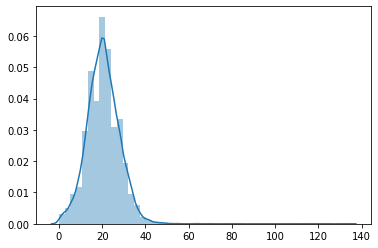

In [0]:
SOS_token = 0 # start of string.
EOS_token = 1 # end of string.


class Lang: # like a vocabulary
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s



def prepareData(texts, titles):
    pairs = list(zip(texts, titles))
    lang = Lang('ru')

    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor)


lang, pairs = prepareData(texts, titles)
print(random.choice(pairs))

lens = [len(t) for t in texts]
sns.distplot(lens)

i = 100
print(texts[i])
print(titles[i])

In [0]:
from random import shuffle

union = []
for pair in tqdm.tqdm(pairs):
  union.append(['SOS']+pair[0]+['EOS'])

for pair in tqdm.tqdm(pairs):
  union.append(['SOS']+pair[1]+['EOS'])

shuffle(union)

100%|██████████| 10000/10000 [00:00<00:00, 734168.39it/s]


# Prepear word embeddings

In [0]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

model = Word2Vec(union, 
                 min_count = 0, 
                 workers=cpu_count(),
                 size=100,
                 window=10,
                 negative=5
                )

In [0]:
init_voc = set(lang.word2index.keys())
wv_voc = set(model.wv.vocab.keys())
print(wv_voc - init_voc)
print(init_voc - wv_voc)
assert(len(init_voc)==len(wv_voc))

set()
set()


In [0]:
word_init_vectors = {}
for w in model.wv.vocab:
    word_init_vectors[w] = model[w].tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Another way


In [0]:
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(10)]
training_pair = training_pairs[0]
input_tensor = training_pair[0]
target_tensor = training_pair[1]

def indices_to_text(sentence):
  print([lang.index2word[w.numpy()[0]] for w in sentence])

indices_to_text(input_tensor)
indices_to_text(target_tensor)

['единый', 'страна', 'еврозона', 'валюта', 'увеличиваться', 'цена', 'отношение', 'доллар', 'торг', 'четверг', 'фон', 'ожидание', 'инвестор', 'повод', 'решение', 'европейский', 'центральный', 'банка', 'ецб', 'ставка', 'также', 'прогноз', 'экономика', 'еврозона', 'сообщать', 'агентство', 'ассошиэйтед', 'пресс', 'EOS']
['евро', 'четверг', 'дорожать', 'доллар', 'ожидание', 'решение', 'ецб', 'ставка', 'EOS']


In [0]:
# encoder: 3 layer lstm. 
# gets input idices
# returns hidden states for each word and 

learning_rate = 0.001
hidden_size = 100


global_embeddings = nn.Embedding(lang.n_words, hidden_size)
wv = torch.Tensor([word_init_vectors[lang.index2word[idx]] for idx in lang.index2word.keys()])
global_embeddings.weight.data = wv

encoder_gru = nn.GRU(hidden_size, hidden_size)

decoder_gru = nn.GRU(hidden_size*2, hidden_size) 
decoder_linear = nn.Linear(hidden_size, lang.n_words)


encoder_optimizer = optim.Adam(list(encoder_gru.parameters())+list(global_embeddings.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(list(decoder_gru.parameters())+list(decoder_linear.parameters()), lr=learning_rate)

In [0]:
try:
  del criterion
  del encoder_optimizer
  del decoder_optimizer
  del loss
except:
  print("init")
  pass

batch_size = 512 # 1024
n_epochs = 10 # 5
learning_rate = 0.005

criterion = nn.NLLLoss()
encoder_optimizer = optim.Adam(list(encoder_gru.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(list(decoder_gru.parameters())+list(decoder_linear.parameters()), lr=learning_rate)

init


In [0]:
try:
  del criterion
  del encoder_optimizer
  del decoder_optimizer
  del loss
except:
  print("init")
  pass

batch_size = 1024 # 1024
n_epochs = 10 # 5
learning_rate = 0.005

criterion = nn.NLLLoss()
encoder_optimizer = optim.Adam(list(encoder_gru.parameters())+list(global_embeddings.parameters()), lr=learning_rate)
decoder_optimizer = optim.Adam(list(decoder_gru.parameters())+list(decoder_linear.parameters()), lr=learning_rate)

In [0]:
batch_num = len(pairs)//batch_size

losses = []

for n_epoch in range(n_epochs):
  epoch_loss = 0
  divider = 0
  recalls = []

  for batch_i in tqdm.tqdm(range(batch_num-1)): # batch cycle

    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    training_pairs = pairs[batch_i*batch_size : (batch_i+1)*batch_size]
    training_pairs = [tensorsFromPair(p) for p in training_pairs]
    for tpi, training_pair in enumerate(training_pairs):
      input_tensor = training_pair[0]
      target_tensor = training_pair[1]

      input_length = input_tensor.shape[0]
      encoder_outputs = torch.zeros(input_length, hidden_size, device=device)
      encoder_hidden =  torch.zeros(1, 1, hidden_size, device=device) # init


      for ei in range(input_length):
          embedded = global_embeddings(input_tensor[ei]).view(1, 1, -1)
          encoder_output, encoder_hidden = encoder_gru(embedded, encoder_hidden)
          encoder_outputs[ei] = encoder_output[0, 0]


      decoder_hidden = encoder_hidden # charge with last encoder hidden
      next_target_token = torch.tensor([[SOS_token]], device=device) # start decoding with
      target_length = target_tensor.shape[0]
      divider += target_length

      recall = 0
      # Teacher forcing: Feed the target as the next input
      for di in range(target_length):

        attn_weigths = nn.functional.softmax(torch.bmm(encoder_outputs.unsqueeze(0), decoder_hidden.permute(0,2,1)).squeeze(0), dim=0)
        # or here can be encoder hiddens
        attn_applied =  torch.bmm(encoder_outputs.T.unsqueeze(0), attn_weigths.unsqueeze(0)).squeeze(0).T
        decoder_input = torch.cat([global_embeddings(next_target_token[0]), attn_applied], dim=1).unsqueeze(0) # Teacher forcing

        decoder_output, decoder_hidden = decoder_gru(decoder_input, decoder_hidden)

        decoder_predict = torch.nn.functional.log_softmax(decoder_linear(decoder_output[0]), dim=1)
        recall += torch.argmax(decoder_predict) == target_tensor[di]
        loss += criterion(decoder_predict, target_tensor[di])
        next_target_token = target_tensor[di].unsqueeze(0)

        # print(f"Generated: {lang.index2word[torch.argmax(decoder_predict).item()]} | True: {lang.index2word[target_tensor[di].item()]}")
      recalls.append(1.0*recall/target_length)


    epoch_loss += loss.item()/divider
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
  
  losses.append(epoch_loss)
  print(f"epoch: {n_epoch} - loss: {epoch_loss} - mean recall: {(sum(recalls)/len(recalls)).item()}")

NameError: ignored

# look into caches

In [0]:
batch_num

19

342
10000


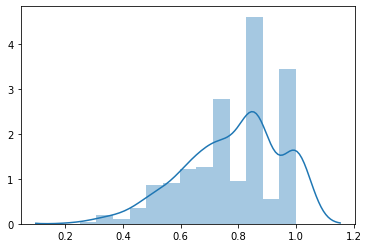

In [0]:
print(len(recalls))
print(len(pairs))
sns.distplot(recalls)

In [0]:
recalls[0]

tensor([0.8889])

In [0]:
indices_to_text(target_pairs[0][0])
print([lang.index2word[w.detach().numpy().tolist()] for w in target_pairs[0][1]])

['большинство', 'ребёнок', 'который', 'пытаться', 'увезти', 'сша', 'гаити', 'сирота', 'EOS']
['британский', 'ребёнок', 'который', 'пытаться', 'увезти', 'сша', 'гаити', 'сирота', 'EOS']


# Inference

In [0]:
test_pair = random.choice(pairs)

ttest_pair = tensorsFromPair(test_pair)
input_tensor = ttest_pair[0]
target_tensor = ttest_pair[1]
target_inference = []
recall = 0

with torch.no_grad():
  input_length = input_tensor.shape[0]
  encoder_outputs = torch.zeros(input_length, hidden_size, device=device)
  encoder_hidden =  torch.zeros(1, 1, hidden_size, device=device) # init


  for ei in range(input_length):
      embedded = global_embeddings(input_tensor[ei]).view(1, 1, -1)
      encoder_output, encoder_hidden = encoder_gru(embedded, encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]


  decoder_hidden = encoder_hidden # charge with last encoder hidden
  next_target_token = torch.tensor([[SOS_token]], device=device) # start decoding with
  target_length = target_tensor.shape[0]


  for di in range(target_length):
    attn_weigths = nn.functional.softmax(torch.bmm(encoder_outputs.unsqueeze(0), decoder_hidden.permute(0,2,1)).squeeze(0), dim=0)
    # or here can be encoder hiddens
    attn_applied =  torch.bmm(encoder_outputs.T.unsqueeze(0), attn_weigths.unsqueeze(0)).squeeze(0).T
    decoder_input = torch.cat([global_embeddings(next_target_token[0]), attn_applied], dim=1).unsqueeze(0) # Teacher forcing

    decoder_output, decoder_hidden = decoder_gru(decoder_input, decoder_hidden)

    decoder_predict = torch.nn.functional.log_softmax(decoder_linear(decoder_output[0]), dim=1)

    recall += torch.argmax(decoder_predict) == target_tensor[di]
    target_inference.append(torch.argmax(decoder_predict))
    next_target_token = target_tensor[di].unsqueeze(0)
    # next_target_token = torch.Tensor([]) target_tensor[di].unsqueeze(0)
    # print(torch.argmax(decoder_predict))
    # print(next_target_token)

  print(f"recall: {1.0*recall/target_length}")

print(f"Input: {' '.join(test_pair[0])}")
print(f"Target: {' '.join(test_pair[1])}")
# indices_to_text(target_tensor)
print([lang.index2word[w.numpy().tolist()] for w in target_inference])

recall: tensor([0.1429])
Input: замглавы мид израиль данни аялоно выступить специальный заявление повод инцидент посол турция пообещать будущее использовать приемлемый дипломатический средство
Target: замглавы мид израиль пообещать оскорблять дипломат
['меркель', 'подписать', 'рф', 'контракт', 'развитие', 'оружие', 'EOS']


In [0]:
torch.argmax(decoder_predict)

tensor(1)